In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from PIL import Image


import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import image_dataset_from_directory
from tensorflow.data import Dataset

from keras.metrics import Precision, Recall
import random
import matplotlib.image as mpimg

In [8]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

# print(len(tf.config.list_physical_devices('GPU')))
# tf.config.set_visible_devices([], "CPU")
# tf.config.set_visible_devices(gpus[0], 'GPU' )
# tf.config.get_visible_devices()

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

Load Data

In [9]:

path = '/content/drive/MyDrive/Colab Notebooks/kvasir'

In [10]:
#generate data object keras
data = image_dataset_from_directory(path, label_mode= "categorical")

scaled_data = data.map(lambda x,y: (x/255,y))

#access data from keras data object
data_iterator= data.as_numpy_iterator()

#image batches as np arrays
batch= data_iterator.next()

Found 4000 files belonging to 8 classes.


In [11]:
len(data)

125

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


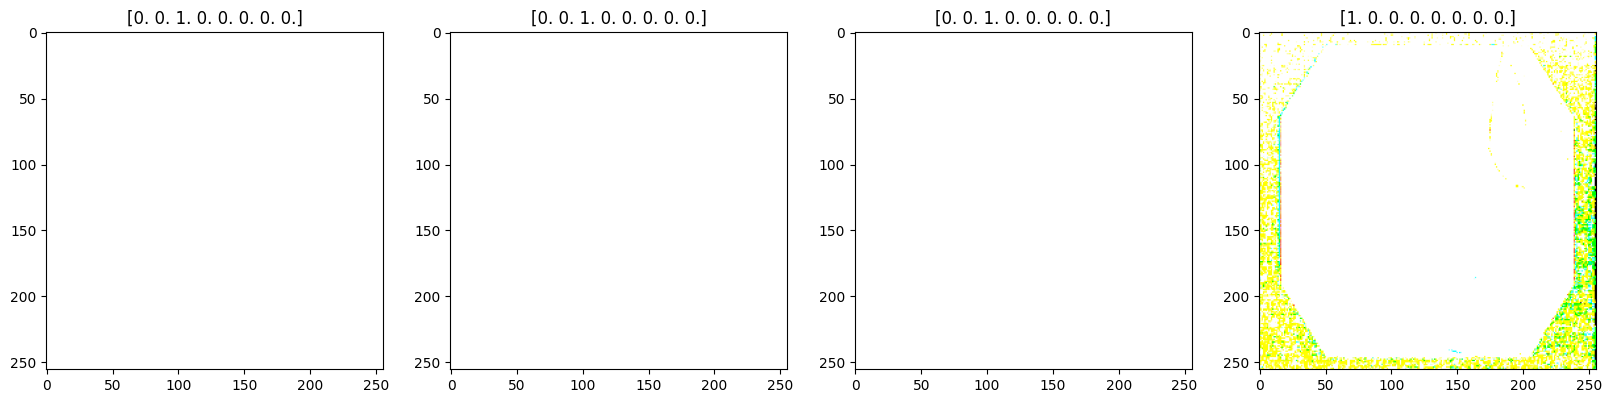

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split Data into Train, Validation and Test

In [13]:
train_size = int(len(data)*.75)
val_size = int(len(data)*.2)
test_size = int(len(data)*.05)

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Cerate Model

In [15]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(Conv2D(32, (4,4), 2, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (2,2), 1, activation='relu'))
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [16]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        8

In [17]:
# logdir='logs'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:

hist = model.fit(train, epochs=20, validation_data=val)

model.save("model.keras")
print("model saved")

Epoch 1/20
93/93 [==============================] - 232s 2s/step - loss: 0.5367 - accuracy: 0.4795 - val_loss: 0.1655 - val_accuracy: 0.6825
Epoch 2/20
93/93 [==============================] - 17s 177ms/step - loss: 0.1841 - accuracy: 0.6381 - val_loss: 0.1652 - val_accuracy: 0.6725
Epoch 3/20
93/93 [==============================] - 17s 178ms/step - loss: 0.1595 - accuracy: 0.6959 - val_loss: 0.1693 - val_accuracy: 0.6662
Epoch 4/20
93/93 [==============================] - 17s 180ms/step - loss: 0.1609 - accuracy: 0.7107 - val_loss: 0.1652 - val_accuracy: 0.6862
Epoch 5/20
93/93 [==============================] - 17s 177ms/step - loss: 0.1390 - accuracy: 0.7433 - val_loss: 0.1475 - val_accuracy: 0.7275
Epoch 6/20
93/93 [==============================] - 17s 177ms/step - loss: 0.1301 - accuracy: 0.7658 - val_loss: 0.1525 - val_accuracy: 0.7312
Epoch 7/20
93/93 [==============================] - 18s 188ms/step - loss: 0.1126 - accuracy: 0.8044 - val_loss: 0.1456 - val_accuracy: 0.7375
E

Evaluate

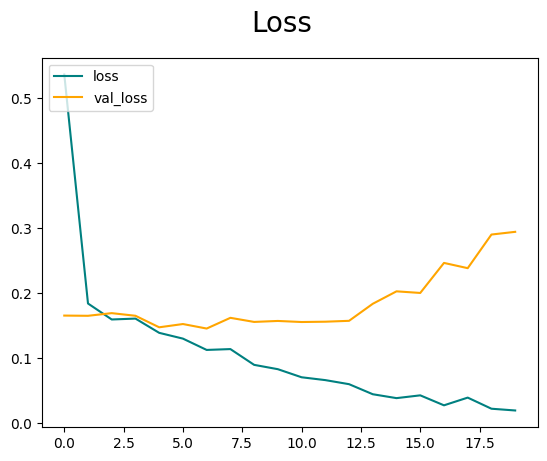

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

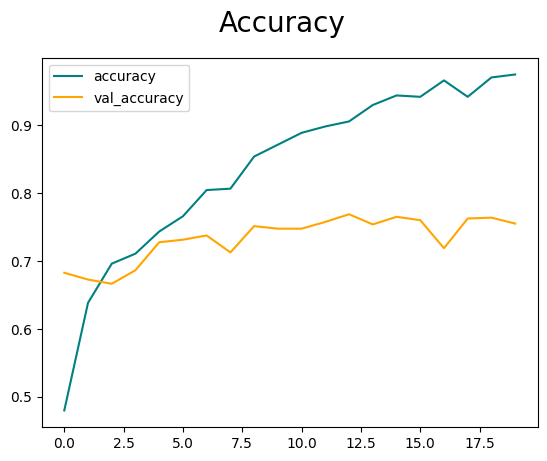

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Precision, Recall ve F1 Score hesaplama
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(yhat, axis=1).numpy())

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)



1/1 [==============================] - 0s 28ms/step


   Class  Precision    Recall  F1 Score
0      0   0.500000  0.736842  0.595745
1      1   0.666667  0.454545  0.540541
2      2   0.909091  0.645161  0.754717
3      3   1.000000  0.750000  0.857143
4      4   0.966667  0.852941  0.906250
5      5   0.444444  0.857143  0.585366
6      6   0.777778  0.750000  0.763636
7      7   0.821429  0.958333  0.884615


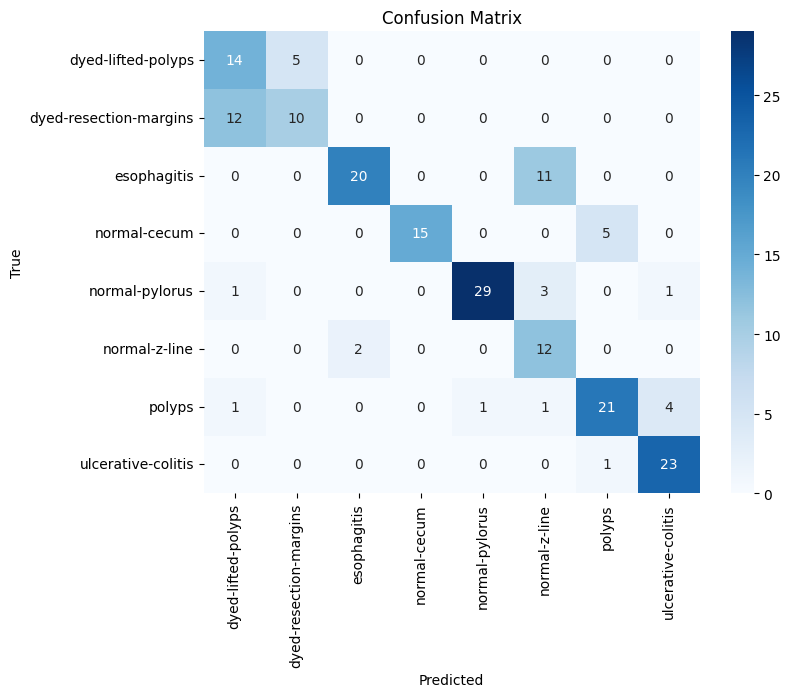

In [22]:
# Sonuçları tablo şeklinde gösterme
metrics_df = pd.DataFrame({'Class': range(8), 'Precision': precision, 'Recall': recall, 'F1 Score': f1})
print(metrics_df)

# Confusion Matrix çizme
cm = confusion_matrix(y_true, y_pred)
class_names =  os.listdir(path)
class_names = sorted(class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()